<a href="https://colab.research.google.com/github/dreamboysatvik/CASIA2.0-ELA_FEATURE_FORGERY_CLASSIFICATION/blob/main/casia2_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"satvik6601","key":"df0920e216bc40e99f9bbfba35379226"}'}

In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
# !kaggle datasets download -d divg07/casia-20-image-tampering-detection-dataset

In [7]:
# !unzip casia-20-image-tampering-detection-dataset.zip

In [8]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [9]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [10]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

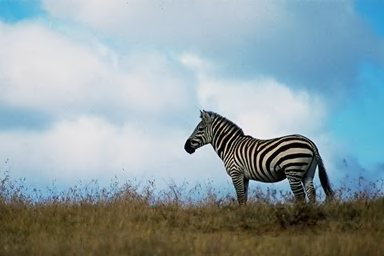

In [11]:
real_image_path = '/content/CASIA2/Au/Au_ani_00001.jpg'
Image.open(real_image_path)

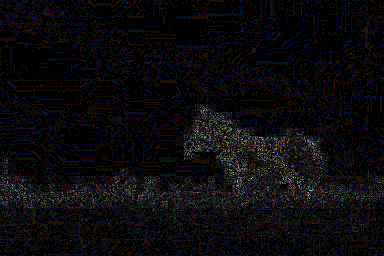

In [12]:
convert_to_ela_image(real_image_path, 90)

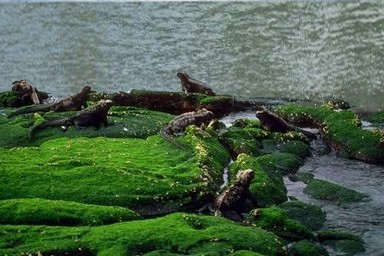

In [13]:
fake_image_path = '/content/CASIA2/Tp/Tp_D_CND_M_N_ani00018_sec00096_00138.tif'
Image.open(fake_image_path)

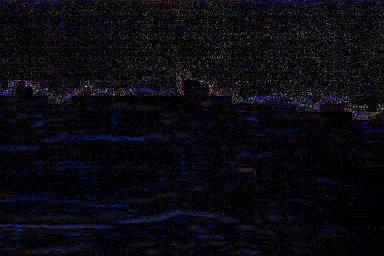

In [14]:
convert_to_ela_image(fake_image_path, 90)

In [15]:
image_size = (128, 128)

In [16]:
def prepare_image(image_path):
  return np.array(convert_to_ela_image(image_path,90).resize(image_size)).flatten() / 255.0

In [17]:
  X = []
  Y = []
  

In [18]:
import random
path = '/content/CASIA2/Au/'
for dirname, _, filenames in os.walk(path):
  for filename in filenames:
    if filename.endswith('jpg') or filename.endswith('png'):
      full_path = os.path.join(dirname,filename)
      X.append(prepare_image(full_path))
      Y.append(1)
      if len(Y)%500 == 0:
        print(f'Processing {len(Y)} images')



/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images


In [19]:
print(len(X), len(Y))

7437 7437


In [20]:


path = '/content/CASIA2/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 7500 images
Processing 8000 images
Processing 8500 images
Processing 9000 images
Processing 9500 images
9501 9501


In [21]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.25, random_state=5)
X_test, X_val, Y_test, Y_val = train_test_split(X_test,Y_test ,test_size = 0.75,random_state=5 )

X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))
print(len(X_test), len(Y_test))

7125 7125
1782 1782
594 594


In [23]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [24]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               29491456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [25]:
epochs = 30
batch_size = 32
init_lr = 1e-4
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [26]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [27]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [28]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/30
223/223 [==============================] - 54s 46ms/step - loss: 0.4285 - accuracy: 0.7827 - val_loss: 0.2823 - val_accuracy: 0.8586
Epoch 2/30
223/223 [==============================] - 9s 39ms/step - loss: 0.2915 - accuracy: 0.8446 - val_loss: 0.2620 - val_accuracy: 0.8737
Epoch 3/30
223/223 [==============================] - 9s 39ms/step - loss: 0.2748 - accuracy: 0.8662 - val_loss: 0.2458 - val_accuracy: 0.8872
Epoch 4/30
223/223 [==============================] - 9s 39ms/step - loss: 0.2400 - accuracy: 0.8824 - val_loss: 0.2377 - val_accuracy: 0.8928
Epoch 5/30
223/223 [==============================] - 9s 39ms/step - loss: 0.2352 - accuracy: 0.8845 - val_loss: 0.2001 - val_accuracy: 0.9175
Epoch 6/30
223/223 [==============================] - 9s 39ms/step - loss: 0.1974 - accuracy: 0.9137 - val_loss: 0.1868 - val_accuracy: 0.9153
Epoch 7/30
223/223 [==============================] - 9s 39ms/step - loss: 0.1859 - accuracy: 0.9194 - val_loss: 0.1859 - val_accuracy: 0.924

In [29]:
class_names = ['fake', 'real']

In [30]:
yhat = model.predict(X_test)

In [31]:
yhat = (yhat > 0.5) 
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test, yhat)
print('Accuracy: %.3f' % (accuracy * 100))

Accuracy: 92.929
